<a href="https://colab.research.google.com/github/MP-cod/PyTorch-fundamentals-25-hours-workshop-/blob/main/pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another(there can be multiple things as the options).


Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/
All other resources- [Dan's git](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbUIzc2pJVnh5T1dkYnNaVzhTZ0ZmVnhZUGMxQXxBQ3Jtc0traTFFcTZVNml2a1I0bG1vTm9BTnpNakNkTEZhQnFtNU03NzIwNEhLRDltTW5mbkZKZ3ZkZ3l2UEhmRkR3OXZnZ1FrSlZDTVVlY0lRaXg0NVFCd3B0R2hGRWsyc19lYkZaWVJvOXRJRldYWlB1RzJmMA&q=https%3A%2F%2Fgithub.com%2Fmrdbourke%2Fpytorch-deep-learning&v=V_xro1bcAuA)

##1. Make classification data and get ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

#make 1000 samples
n_samples=1000

#create circles
X, y=make_circles(n_samples,
                  noise=0.03,
                  random_state=42)


In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"first five samples of X: \n{X[:5]}")
print(f"first five samples of y: \n{y[:5]}")

first five samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first five samples of y: 
[1 1 1 1 0]


In [ ]:
#make Dataframe of circle data
import pandas as pd

circles=pd.DataFrame({"X1": X[:,0],
                      "X2": X[:,1],
                      "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


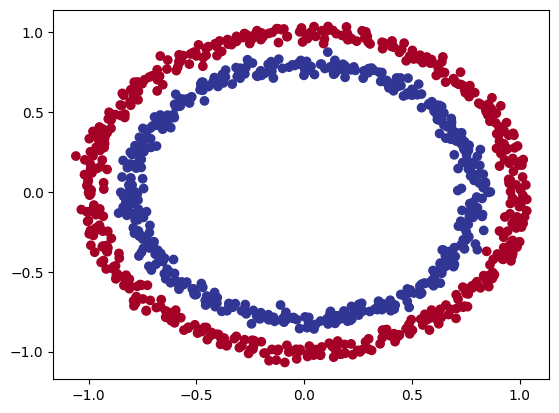

In [ ]:
#visualise visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** the data we're working with is often referred to as toy dataset, a dataset small enough to experiment but sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape


((1000, 2), (1000,))

In [ ]:
#view the first example of features and labels
X_sample=X[0]
y_sample=y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into Tensors and create train and test splits

In [ ]:
#turn data into tensors
import torch
torch.__version__

'2.3.0+cu121'

In [ ]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [ ]:
#turn data into tensors(turns out mine was already a tensor :D not really after rebooting TT)
X=torch.tensor(X, dtype=torch.float)
y=torch.tensor(y, dtype=torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# torch.manual_seed(42) #will only pytorch code and not scikit learn part of the code

In [ ]:
#split data into training and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,
                                                  y,
                                                  test_size=0.2, # 0.2=20% of data to be tested & 80% trained
                                                  random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to,
1. Setup device agnostic code so our code will run on an accelerator(GPU) if there is one,
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
#import pytorch and nn
import torch
from torch import nn

#make device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
X_train, X_test[:10]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         ...,
         [ 0.0157, -1.0300],
         [ 1.0110,  0.1680],
         [ 0.5578, -0.5709]]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]))

Now we've setup device agnostic code, let's create a model that

1. Subclasses `nn.Module` (almost all models in pytorch subclass `nn.Module`)
2. create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. instantiate an instance of our model class and send it to target `device`

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [ ]:
# 1. construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
      super().__init__()
      # 2. create 2 nn.Linear layers capable of handling the shapes of our data
      self.layer_1=nn.Linear(in_features=2, out_features=5)  #takes in 2 features and upscales to 5 features
      self.layer_2=nn.Linear(in_features=5, out_features=1) #takes in 5 features from previous layer and outputs a single feature(same shape as y)

    #3. define a forward() method that outlines the forward pass
  def forward(self, x):
      # Return the output of layer_2, a single feature, the same shape as y
      return self.layer_2(self.layer_1(x))  # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Instantiate an instance of our model class and send it to the target device
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# let's replicate the model above using `nn.Sequential()`
model_0=nn.Sequential(
  nn.Linear(in_features=2, out_features=5),
  nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# make some predictions
untrained_preds= model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 setup loss function and optimizer

which loss function or optimizer should you use?

Again.. this is problem specific

For example for regression you might want MAE or MSE(mean absolute error or mean squared error)
For classification you might want a binary cross entropy or categorical cross entropy(cross entropy)

As a reminder, loss function measures how *wrong* your model's predictions are.

And for optimizers, two of the most common and useful are SDG and Adam, however, PyTorch has a lot in-built options.

* for the loss functions we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* for a definition on what logit is in DL- https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow
* for different optimizers see `torch.optim`

In [ ]:
# setup loss function
#loss_fn=nn.BCELoss() #requires input to have gone through the sigmoid activation function prior to BCELoss
loss_fn=nn.BCEWithLogitsLoss() #BCEWithLogitsLoss= sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
#calculate accuracy - out of 100 examples, what %age does our model get right
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc= (correct / len(y_pred)) * 100
  return acc

## 3. Train model

to train our model, we're gonna need to build a training loop with following steps:

1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward(backpropagation)
5. Optimizer(gradient descent)

### 3.1 going from raw logits -> prediction probabilities -> prediction labels

Our models are going to be raw **logits**.

we can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

then we can convert our models prediction probabilties -> **prediction labels** by either rounding then ir taking the `argmax()`

In [ ]:
#view the first 5 outputs of the forward pass on the test data
y_logits=model_0(X_test.to(device))[:5]
y_logits
# or we can do this like before
# model_0.eval()
# with torch.inference_mode():
#   y_logits=model_0(X_test.to(device)) [:5]


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# use the sigmoid activation function on our model logits to them into prediction probabilities
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

for our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >=0.5, y=1 (class 1)
* `y_pred_probs` <0.5, y=0 (class 0)


In [ ]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
# find the predicted labels
y_preds=torch.round(y_pred_probs)

# in full(logits -> pred probs -> pred labels)
y_pred_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra squeeze
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)

#set the number of epochs
epochs = 100

#put data to the right device
X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

#build training and evaluation loop
for epoch in range(epochs):
  ###Training
  model_0.train()

  #1.forward pass
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  #2. calculate loss/accuracy
  # loss=loss_fn(torch.sigmoid(y_logits), #nn.BCELoss expects prediction probabilties as input
  #              y_train)
  loss=loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
               y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward(backpropagation)
  loss.backward()

  #5. Optimizer step(gradient descent)
  optimizer.step()

  ###Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #2. calculate test loss/accuracy
    test_loss=loss_fn(test_logits,
                      y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)

    #print out what's happening
  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss: 0.5f}, Acc: {acc:0.2f}% | Test loss: {test_loss: 0.5f}, Test acc: {test_acc: 0.2f}%")

Epoch: 0 | Loss:  0.69796, Acc: 51.88% | Test loss:  0.69440, Test acc:  58.00%
Epoch: 10 | Loss:  0.69590, Acc: 51.25% | Test loss:  0.69305, Test acc:  53.00%
Epoch: 20 | Loss:  0.69490, Acc: 51.62% | Test loss:  0.69254, Test acc:  49.50%
Epoch: 30 | Loss:  0.69435, Acc: 51.12% | Test loss:  0.69236, Test acc:  49.50%
Epoch: 40 | Loss:  0.69401, Acc: 50.88% | Test loss:  0.69232, Test acc:  51.00%
Epoch: 50 | Loss:  0.69378, Acc: 50.25% | Test loss:  0.69234, Test acc:  50.00%
Epoch: 60 | Loss:  0.69362, Acc: 50.00% | Test loss:  0.69239, Test acc:  51.50%
Epoch: 70 | Loss:  0.69351, Acc: 50.25% | Test loss:  0.69246, Test acc:  51.00%
Epoch: 80 | Loss:  0.69342, Acc: 49.88% | Test loss:  0.69254, Test acc:  50.00%
Epoch: 90 | Loss:  0.69336, Acc: 49.88% | Test loss:  0.69262, Test acc:  53.00%


## 4. make predictions and evaluate the model

from the metrics it looks like our model isn't learing anything...

so to inspect it let's make some predictions and make them visual!

in other words, "Visualize, visualize, visualize!"

in order to do so, we're going to import a function called `plot_decision_boundary()` -
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py


In [ ]:
import requests
from pathlib import Path

#download helper_functions from learn pytorch repo(if it's not already download)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exits, skipping download")
else:
  print("download helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exits, skipping download


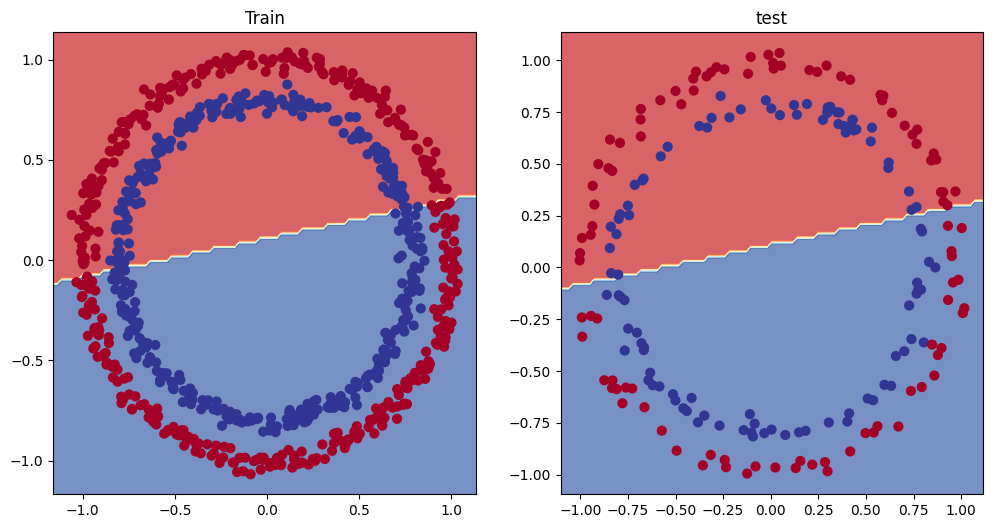

In [ ]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers- give the model more chances to learn about patterns in the data.
* add more hidden units- go from 5 hidden units to 10 hidden units.
* Fit for longer
* changing the activation functions
change the learning rate
* change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options asre all values we(ML engineers & data scientists) can change, they're referred to as **hyperparameter**

Let's tru and improve our model by:
* adding more hidden units 5-->10
* increase the number of layers: 2->3
* increase the number of epochs 100->1000

In [ ]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2, out_features=10)
    self.layer_2=nn.Linear(in_features=10, out_features=10)
    self.layer_3=nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z=self.layer_1(x)
    # z=self.layer_2(z)
    # z=self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes


model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#create a loss function
loss_fn=nn.BCEWithLogitsLoss()

#create an optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

In [ ]:
# write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#train for longer
epochs=1000

#put data to the right device
X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

#build training and evaluation loop
for epoch in range(epochs):
  ###Training
  model_1.train()

  #1.forward pass
  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  # calculate loss accuracy
  loss=loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
               y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward(backpropagation)
  loss.backward()

  #5. Optimizer step(gradient descent)
  optimizer.step()

  ###Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #2. calculate test loss/accuracy
    test_loss=loss_fn(test_logits,
                      y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)
  #print out what's happening
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss: 0.5f}, Acc: {acc:0.2f}% | Test loss: {test_loss: 0.5f}, Test acc: {test_acc: 0.2f}%")

Epoch: 0 | Loss:  0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc:  51.00%
Epoch: 100 | Loss:  0.69305, Acc: 50.38% | Test loss:  0.69379, Test acc:  48.00%
Epoch: 200 | Loss:  0.69299, Acc: 51.12% | Test loss:  0.69437, Test acc:  46.00%
Epoch: 300 | Loss:  0.69298, Acc: 51.62% | Test loss:  0.69458, Test acc:  45.00%
Epoch: 400 | Loss:  0.69298, Acc: 51.12% | Test loss:  0.69465, Test acc:  46.00%
Epoch: 500 | Loss:  0.69298, Acc: 51.00% | Test loss:  0.69467, Test acc:  46.00%
Epoch: 600 | Loss:  0.69298, Acc: 51.00% | Test loss:  0.69468, Test acc:  46.00%
Epoch: 700 | Loss:  0.69298, Acc: 51.00% | Test loss:  0.69468, Test acc:  46.00%
Epoch: 800 | Loss:  0.69298, Acc: 51.00% | Test loss:  0.69468, Test acc:  46.00%
Epoch: 900 | Loss:  0.69298, Acc: 51.00% | Test loss:  0.69468, Test acc:  46.00%


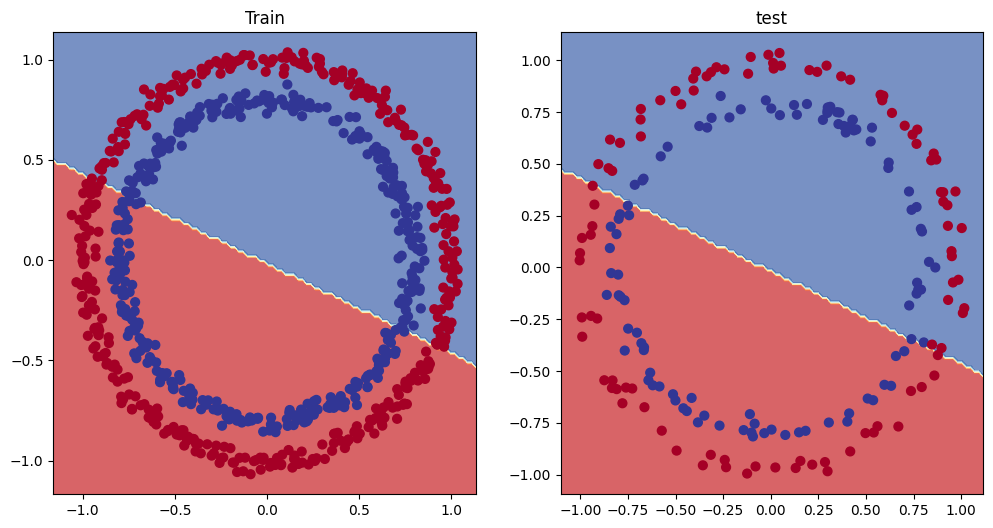

In [ ]:
#plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

one way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
# create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#create data
X_regression=torch.arange(start, end, step).unsqueeze(dim=1)
y_regression=weight * X_regression + bias #linear regression formula without epsilon

#check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# create train and test split
train_split=int(0.8 * len(X_regression))
X_train_regression, y_train_regression=X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression=X_regression[train_split:], y_regression[train_split:]

#check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

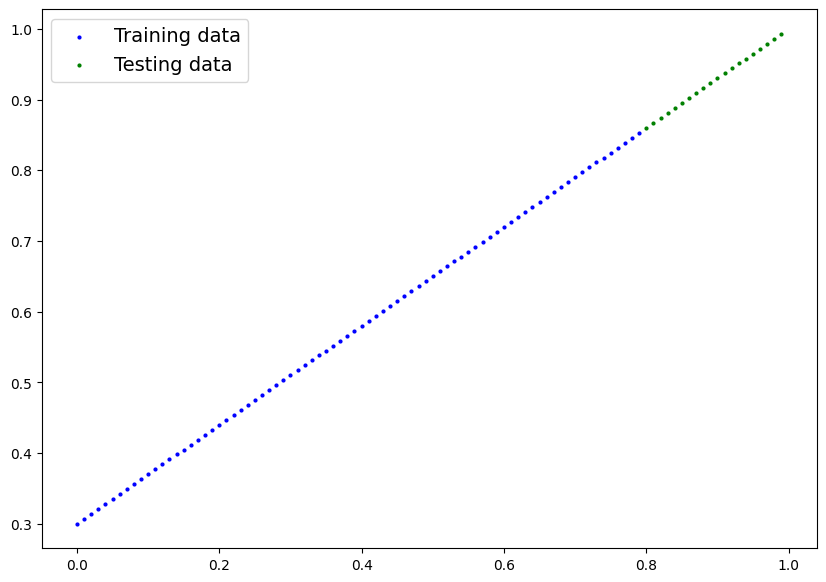

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

In [ ]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting ``model_1`` to fit a straight line

In [ ]:
#Same architecture as model_1 (but using nn.Sequential())
model_2=nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#loss and optmizer
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                          lr=0.01)

In [ ]:
#train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set the humber of epochs
epochs=1000

#put the data on the target device
X_train_regression, y_train_regression=X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression=X_test_regression.to(device), y_test_regression.to(device)

#training
for epoch in range(epochs):
  y_pred=model_2(X_train_regression)
  loss=loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  model_2.eval()
  with torch.inference_mode():
    test_pred= model_2(X_test_regression)
    test_loss= loss_fn(test_pred, y_test_regression)

  #print out what's happening
  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss: {loss:0.5f} | Test loss: {test_loss: 0.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss:  0.91103
Epoch: 100 | Loss: 0.02858 | Test loss:  0.00081
Epoch: 200 | Loss: 0.02533 | Test loss:  0.00209
Epoch: 300 | Loss: 0.02137 | Test loss:  0.00305
Epoch: 400 | Loss: 0.01964 | Test loss:  0.00341
Epoch: 500 | Loss: 0.01940 | Test loss:  0.00387
Epoch: 600 | Loss: 0.01903 | Test loss:  0.00379
Epoch: 700 | Loss: 0.01878 | Test loss:  0.00381
Epoch: 800 | Loss: 0.01840 | Test loss:  0.00329
Epoch: 900 | Loss: 0.01798 | Test loss:  0.00360


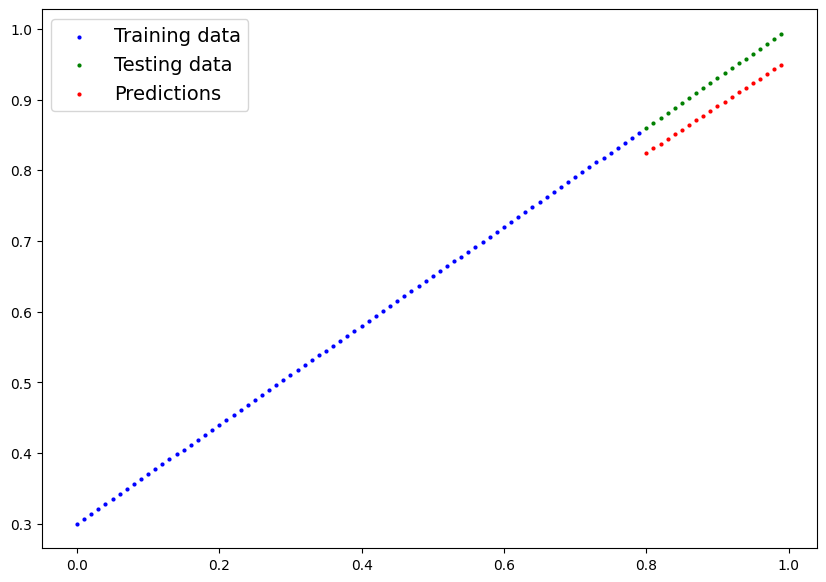

In [ ]:
#turn on evaluation mode
model_2.eval()

#make predictions(inference)
with torch.inference_mode():
  y_preds=model_2(X_test_regression)

#plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece : Non-Linearity

"What patterns could you draw if you were given infinite amount of straight and non-straight lines?"

Or in ML terms, an infinite (but really it is finite) linear and non-linear functions?

###6.1 Recreating non-linear data (red & blue circles)

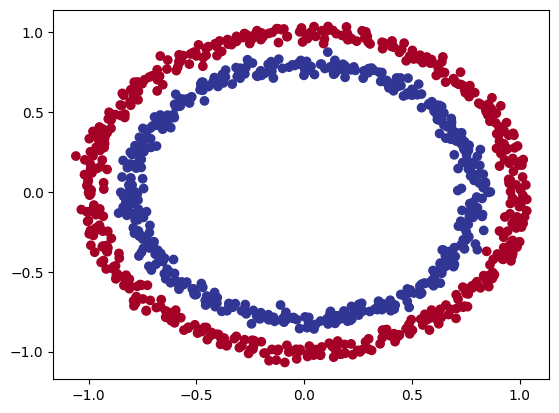

In [ ]:
#make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000

X,y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
#convert data into tensors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

#turn data into tensors
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

#split data into train and test data
X_train, X_test, y_train, y_test=train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

###6.2 Building a model with non-linearity

* Linear-> straight line
* Non-Linear-> not a straight line(parabolas, hyperbolas, etc)

Artificial neural networks are a large number of linear and non-linear functions which are potentially able to find patterns in data.

In [ ]:
#build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2, out_features=10)
    self.layer_2=nn.Linear(in_features=10, out_features=10)
    self.layer_3=nn.Linear(in_features=10, out_features=1)
    self.relu=nn.ReLU()

  def forward(self, x):
    #where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#setup loss_fn and optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_3.parameters(),
                          lr=0.1)

In [ ]:
#random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#put all data on target device
X_train, y_train=X_train.to(device), y_train.to(device)
X_test, y_test=X_test.to(device), y_test.to(device)

#loop through data
epochs=1000

for epoch in range(epochs):
  ###Training
  model_3.train()

  # 1.Forward pass
  y_logits=model_3(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)) #logits->prediction probabilities->prediction labels->output

  # 2. calculate th loss
  loss=loss_fn(y_logits, y_train) #BCEWithLogitsLoss
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  # 3.optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. step the optimizer
  optimizer.step()

  ###Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits, y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)

    #print out what's happening
    if epoch % 100==0:
      print(f"Epoch: {epoch} | Loss: {loss:0.4f}, Acc: {acc:0.2f}% | Test Loss: {test_loss:0.4f}, Test acc: {test_acc:0.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
#make predictions
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]


(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

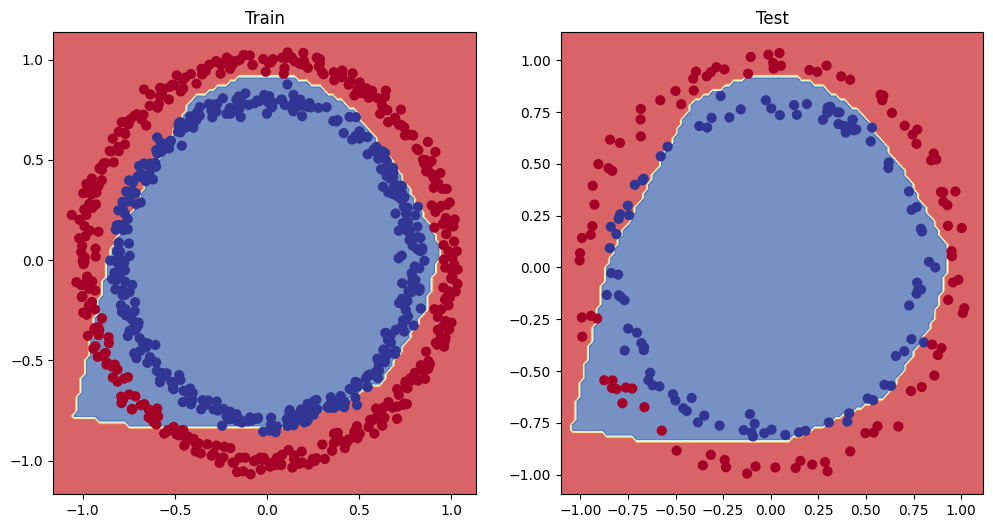

In [ ]:
#plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) #model_1 has no non_linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) #model_3 has non-linearity

## 7. replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are:
* Linear
* Non-linear functions

In [ ]:
#create a tensor
A=torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

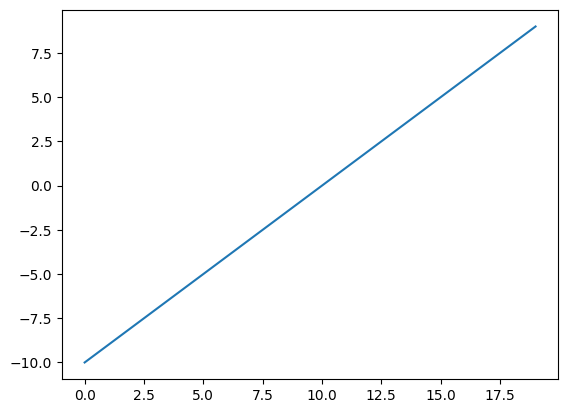

In [ ]:
#visualise the tensor
plt.plot(A);

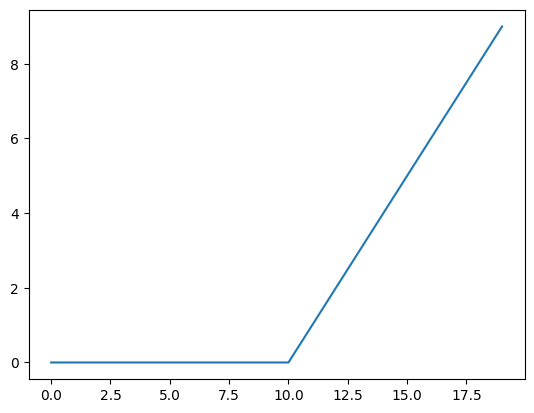

In [ ]:
#using ReLU()
plt.plot(torch.relu(A));

In [ ]:
def relu(x):
  return torch.maximum(torch.tensor(0),x) #inputs must be tensor

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

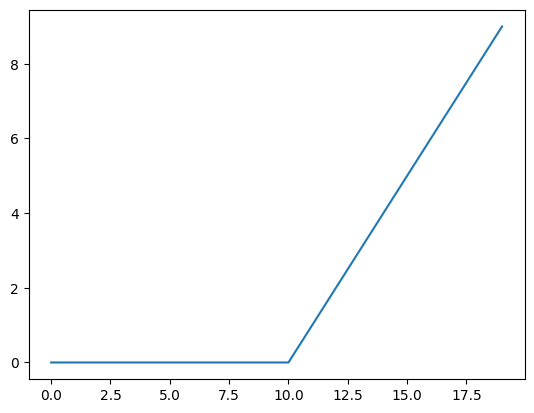

In [ ]:
#plot ReLu activation function
plt.plot(relu(A));

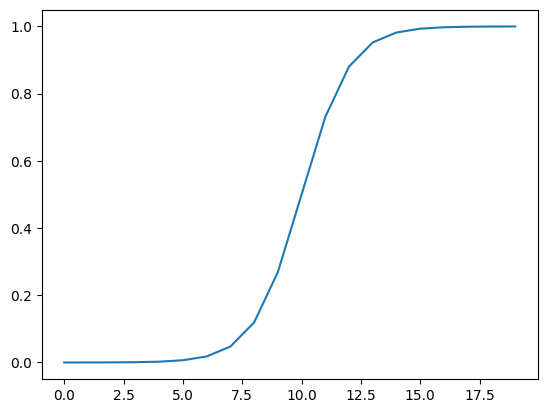

In [ ]:
plt.plot(torch.sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification-> one thing or another(cat vs dog, spam vs not spam, fraud or not fraud)
* Multi-class classification-> more than one thing or another(cat vs dog or chicken)

### 8.1 Creating a toy multi-class dataset

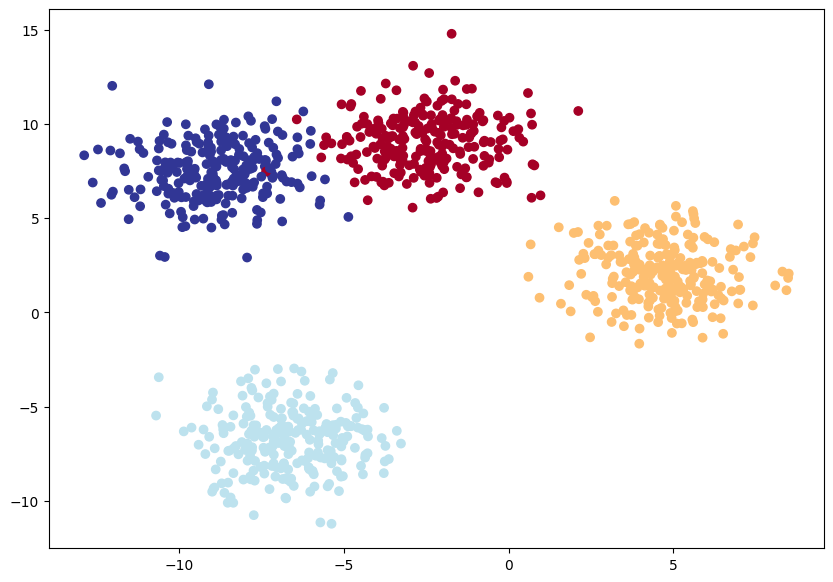

In [ ]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # #https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

#set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES=2
RANDOM_SEED=42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, #give the clusters a little shake up
                            random_state=RANDOM_SEED)
# 2. Turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test=train_test_split(X_blob,
                                                                      y_blob,
                                                                      test_size=0.2,
                                                                      random_state=RANDOM_SEED)

# 4. Plot data(Visualize, Visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# create device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes a multi-class classification model.

    Args:
      input_features(int): Number of input features to the model
      output_features(int): Number of utput features (number of output classes)
      hidden units(int): Number of hidden units between layers, default 8
      Returns:
      """
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

#Create an instance of BlobModel and send it to the target device
model_4=BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [ ]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

### 8.3 Create a loss function and optimizer for the multi-class classification model



In [ ]:
#create a loss_fn and optimizer for multi-class classification model
loss_fn=nn.CrossEntropyLoss()

#create an optimizer for multi-class classification model
optimizer=torch.optim.SGD(params=model_4.parameters(),
                          lr=0.1) #learning rate is a hyperparameter you can change


### 8.4 Getting prediction probabilites for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs(logits) to prediction probabilities and then to prediction labels.

Logits(raw output of the model)-> Pred probs(use `torch.softmax`)-> Pred labels(take the `argmax` of the prediction probabilities)


In [ ]:
#let's get some raw outputs of our model(logits)
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
#convert our model's logit outputs to prediction probabilities
y_pred_probs=torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
#convert our model prediction probabilities -> prediction labels
y_preds=torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 creating a training loop and testing loop for multi-class model

In [ ]:
#fit multi-class model to data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
epochs=100

#put data to target device
X_blob_train, y_blob_train=X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test=X_blob_test.to(device), y_blob_test.to(device)

#loop through data
for epoch in range(epochs):
  ###Training
  model_4.train()

  y_logits=model_4(X_blob_train)
  y_pred=torch.softmax(y_logits, dim=1).argmax(dim=1)

  #calculate the loss
  loss=loss_fn(y_logits, y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,
                  y_pred=y_pred)
  #optimizer zero grad
  optimizer.zero_grad()

  #backward pass
  loss.backward()

  #step the optimizer
  optimizer.step()

  ###testing
  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test)
    test_preds=torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss=loss_fn(test_logits, y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,
                         y_pred=test_preds)

    #print out what's happenin'
    if epoch %10==0:
      print(f"Epoch: {epoch} | Loss: {loss:0.4f}, Acc: {acc:0.2f}% | Test Loss: {test_loss:0.4f}, Test acc: {test_acc:0.2f}%")


Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test Loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test Loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test Loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test Loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test Loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test Loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test Loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test Loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test Loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test Loss: 0.0266, Test acc: 99.50%


### 8.6 making and evaluating predictions with a PyTorch multi-class model

In [ ]:
#make predictions
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test)

#view the first 10 predictions
y_logits[:10]


tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [ ]:
#go from logits-> prediction probabilities
y_pred_probs=torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [ ]:
# go from pred probs-> pred labels
y_pred=torch.argmax(y_pred_probs, dim=1)
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

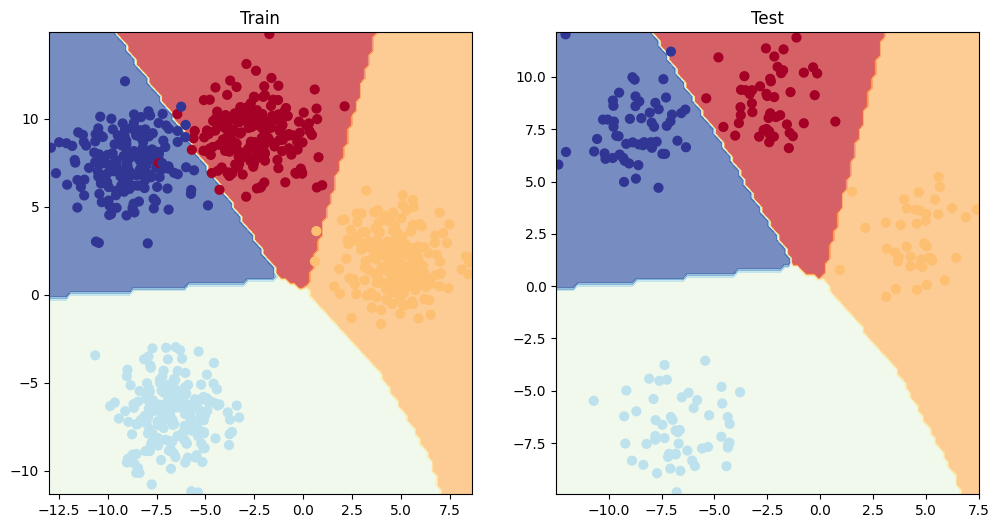

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title( "Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy= our of 100 samples, how many our models can run right?
* precision
* recall
* F1-score
* Confusion matrix
* Classification report

see the article for when to use precision/recall-https://towardsdatascience.com/precision-and-recall-a-simplified-view-bc25978d81e6#:~:text=Understanding%20precision%20and%20recall%20is%20essential%20in%20perfecting,need%20when%20at%20the%20end%20of%20the%20article.

If you want access to a lot of PyTorch metrics, see "torchmetrics docs"